# Apply Trained RoBERTa Model to Backloggd Game Reviews

This notebook uses your trained sentiment analysis model to predict sentiment for all reviews in the backloggd dataset.

## Step 1: Download the Dataset

In [2]:
import os
if os.path.exists('backloggd_game_reviews.csv'):
    print("File found!")
else:
    print("File not found. Please upload it.")

File found!


## Step 2: Load Required Libraries

In [3]:
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from tqdm import tqdm
import numpy as np

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


## Step 3: Load Your Trained Model

Make sure you've already saved your model using `model.save_pretrained('./roberta_sentiment_model')`

In [6]:
# Unzip the model
!unzip -q roberta_sentiment_model.zip

# Verify the model files are there
!ls -la roberta_sentiment_model/

# Load the trained model and tokenizer
print("Loading model and tokenizer...")
model = RobertaForSequenceClassification.from_pretrained('./roberta_sentiment_model')
tokenizer = RobertaTokenizer.from_pretrained('./roberta_sentiment_model')

model = model.to(device)
model.eval()
print("Model loaded successfully!")

replace roberta_sentiment_model/config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace roberta_sentiment_model/special_tokens_map.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace roberta_sentiment_model/special_tokens_map.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
total 488372
drwxr-xr-x 2 root root      4096 Oct 27 20:14 .
drwxr-xr-x 1 root root      4096 Oct 27 20:13 ..
-rw-r--r-- 1 root root       694 Oct 27 19:39 config.json
-rw-r--r-- 1 root root    456318 Oct 27 19:39 merges.txt
-rw-r--r-- 1 root root 498612824 Oct 27 19:39 model.safetensors
-rw-r--r-- 1 root root       958 Oct 27 19:39 special_tokens_map.json
-rw-r--r-- 1 root root      1222 Oct 27 19:39 tokenizer_config.json
-rw-r--r-- 1 root root    999355 Oct 27 19:39 vocab.json
Loading model and tokenizer...
Model loaded successfully!


## Step 4: Load and Explore the Dataset

In [7]:
# Load the dataset
df = pd.read_csv('backloggd_game_reviews.csv')

print(f"Total reviews: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nDataset info:")
print(df.info())
print(f"\nFirst few rows:")
df.head()

Total reviews: 281

Columns: ['Title', 'Review']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   281 non-null    object
 1   Review  281 non-null    object
dtypes: object(2)
memory usage: 4.5+ KB
None

First few rows:


,Title,Review
0,Daggerfall Unity,"Agora sim, devidamente zerado com a história p..."
1,Daggerfall Unity,"i can see why people would enjoy daggerfall, b..."
2,Daggerfall Unity,"They made Daggerfall playable, now you can pla..."
3,Daggerfall Unity,The Elder Scrolls II: Daggerfall (Unity versio...
4,Daggerfall Unity,"I played this with a bunch of audio, visual an..."


## Step 5: Clean the Data

In [8]:
# Clean reviews
df['Review'] = df['Review'].fillna('')
df['Review'] = df['Review'].astype(str)

# Filter out empty reviews
df_filtered = df[df['Review'].str.strip() != ''].copy()
print(f"Reviews after filtering: {len(df_filtered)}")
print(f"Removed {len(df) - len(df_filtered)} empty reviews")

Reviews after filtering: 281
Removed 0 empty reviews


## Step 6: Define Prediction Function

In [9]:
def predict_sentiment_batch(texts, batch_size=32):
    """
    Predict sentiment for a batch of texts
    Returns: predictions (0=negative, 1=positive), confidences, and probabilities
    """
    all_predictions = []
    all_confidences = []
    all_probs = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i + batch_size]

        # Tokenize batch
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        ).to(device)

        # Get predictions
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)
            predictions = torch.argmax(probs, dim=1)
            confidences = torch.max(probs, dim=1)[0]

        all_predictions.extend(predictions.cpu().numpy())
        all_confidences.extend(confidences.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    return all_predictions, all_confidences, all_probs

## Step 7: Run Predictions on All Reviews

In [10]:
# Get predictions
print("Predicting sentiments for all reviews...")
reviews = df_filtered['Review'].tolist()
predictions, confidences, probabilities = predict_sentiment_batch(reviews, batch_size=32)

# Add results to dataframe
df_filtered['sentiment_label'] = predictions
df_filtered['sentiment'] = df_filtered['sentiment_label'].map({0: 'negative', 1: 'positive'})
df_filtered['confidence'] = confidences
df_filtered['prob_negative'] = [prob[0] for prob in probabilities]
df_filtered['prob_positive'] = [prob[1] for prob in probabilities]

print("\nPredictions complete!")

Predicting sentiments for all reviews...


Processing batches: 100%|██████████| 9/9 [04:20<00:00, 28.91s/it]


Predictions complete!


## Step 8: Analyze Results

In [11]:
# Summary statistics
print("="*60)
print("RESULTS SUMMARY")
print("="*60)
print(f"Total reviews processed: {len(df_filtered)}")
print(f"\nSentiment distribution:")
print(df_filtered['sentiment'].value_counts())
print(f"\nPercentages:")
print(df_filtered['sentiment'].value_counts(normalize=True) * 100)
print(f"\nAverage confidence: {df_filtered['confidence'].mean():.4f}")
print(f"\nConfidence by sentiment:")
print(df_filtered.groupby('sentiment')['confidence'].mean())

RESULTS SUMMARY
Total reviews processed: 281

Sentiment distribution:
sentiment
positive    248
negative     33
Name: count, dtype: int64

Percentages:
sentiment
positive    88.256228
negative    11.743772
Name: proportion, dtype: float64

Average confidence: 0.8610

Confidence by sentiment:
sentiment
negative    0.776325
positive    0.872236
Name: confidence, dtype: float32


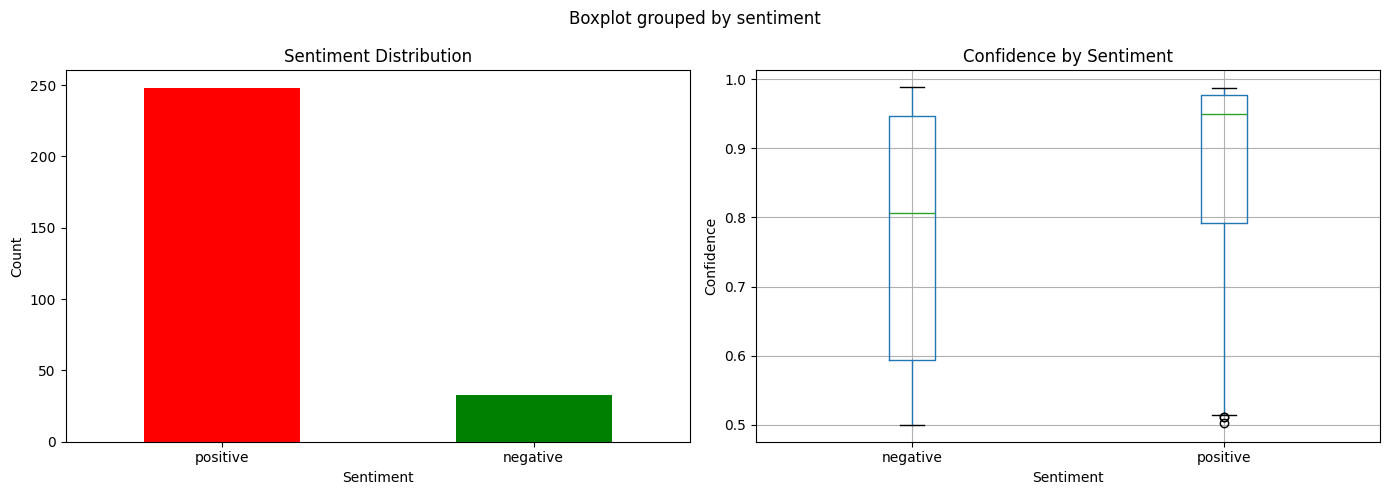

In [12]:
# Visualize sentiment distribution
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sentiment counts
df_filtered['sentiment'].value_counts().plot(kind='bar', ax=axes[0], color=['red', 'green'])
axes[0].set_title('Sentiment Distribution')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Confidence distribution
df_filtered.boxplot(column='confidence', by='sentiment', ax=axes[1])
axes[1].set_title('Confidence by Sentiment')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Confidence')

plt.tight_layout()
plt.show()

## Step 9: Show Sample Predictions

In [13]:
# Show top confident positive reviews
print("TOP 5 MOST CONFIDENT POSITIVE REVIEWS:")
print("="*80)
positive_samples = df_filtered[df_filtered['sentiment'] == 'positive'].nlargest(5, 'confidence')
for idx, row in positive_samples.iterrows():
    print(f"\nTitle: {row.get('Title', 'N/A')}")
    print(f"Review: {row['Review'][:300]}...")
    print(f"Confidence: {row['confidence']:.4f}")
    print("-"*80)

TOP 5 MOST CONFIDENT POSITIVE REVIEWS:

Title: SuperTux
Review: I played this all the way through, all the way completed, multiple times, on both Windows and Mac. I THINK I KNOW WHAT I'M SAYING. This is a really fun platformer with really well drawn designs. I love the artstyle, music, and gameplay of this game. I don't care that it isn't finished, I love it! It...
Confidence: 0.9876
--------------------------------------------------------------------------------

Title: OpenTTD
Review: I played this a while ago, for a long time, off of Steam, and I enjoyed it. Another cool sandbox that runs way deeper than I could ever get into it....
Confidence: 0.9871
--------------------------------------------------------------------------------

Title: SuperTux
Review: what you're referring to as supertux is in fact gnu/supertux, or as I've taken to calling it, gnu + supertuxI've followed development on this game since 0.3.X, playing most major releases since. progress has been glacial (pardon th

In [14]:
# Show top confident negative reviews
print("TOP 5 MOST CONFIDENT NEGATIVE REVIEWS:")
print("="*80)
negative_samples = df_filtered[df_filtered['sentiment'] == 'negative'].nlargest(5, 'confidence')
for idx, row in negative_samples.iterrows():
    print(f"\nTitle: {row.get('Title', 'N/A')}")
    print(f"Review: {row['Review'][:300]}...")
    print(f"Confidence: {row['confidence']:.4f}")
    print("-"*80)

TOP 5 MOST CONFIDENT NEGATIVE REVIEWS:

Title: Daggerfall Unity
Review: I sometimes imagine this game as a great RPG sandbox, but then when I play it the amount of artificiality just... comes crashing down.I WANT to love it, but I can only LIKE it....
Confidence: 0.9882
--------------------------------------------------------------------------------

Title: NetHack
Review: Hated farming resources. Also I have spent way too much time on this game......
Confidence: 0.9816
--------------------------------------------------------------------------------

Title: Mindustry
Review: Only 20 mins play time, so I won't rate it. It's a basic Factorio with tower defence elements. I just didn't like the look, or the interactivity. I imagine in later 'levels' resources will be scarce so defences have to be picked wisely, but I just wasn't bothered....
Confidence: 0.9797
--------------------------------------------------------------------------------

Title: Daggerfall Unity
Review: I loved the origi

## Step 10: Save Results

In [15]:
# Save results to CSV
output_filename = 'backloggd_reviews_with_sentiment.csv'
df_filtered.to_csv(output_filename, index=False)
print(f"Results saved to: {output_filename}")

# Download the file (Google Colab)
from google.colab import files
files.download(output_filename)

Results saved to: backloggd_reviews_with_sentiment.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Create and save summary statistics
summary = {
    'total_reviews': len(df_filtered),
    'positive_reviews': (df_filtered['sentiment'] == 'positive').sum(),
    'negative_reviews': (df_filtered['sentiment'] == 'negative').sum(),
    'positive_percentage': (df_filtered['sentiment'] == 'positive').sum() / len(df_filtered) * 100,
    'negative_percentage': (df_filtered['sentiment'] == 'negative').sum() / len(df_filtered) * 100,
    'avg_confidence': df_filtered['confidence'].mean(),
    'avg_confidence_positive': df_filtered[df_filtered['sentiment'] == 'positive']['confidence'].mean(),
    'avg_confidence_negative': df_filtered[df_filtered['sentiment'] == 'negative']['confidence'].mean(),
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv('sentiment_analysis_summary.csv', index=False)
print(f"Summary saved to: sentiment_analysis_summary.csv")

# Show summary
print("\nFinal Summary:")
summary_df

Summary saved to: sentiment_analysis_summary.csv

Final Summary:


,total_reviews,positive_reviews,negative_reviews,positive_percentage,negative_percentage,avg_confidence,avg_confidence_positive,avg_confidence_negative
0,281,248,33,88.256228,11.743772,0.860972,0.872236,0.776325


## Step 11: Analyze by Game Title (Optional)

In [ ]:
# Aggregate sentiment by game title
if 'Title' in df_filtered.columns:
    game_sentiment = df_filtered.groupby('Title').agg({
        'sentiment': lambda x: (x == 'positive').sum() / len(x) * 100,
        'confidence': 'mean',
        'Review': 'count'
    }).rename(columns={
        'sentiment': 'positive_percentage',
        'confidence': 'avg_confidence',
        'Review': 'review_count'
    })

    # Filter games with at least 5 reviews
    popular_games = game_sentiment[game_sentiment['review_count'] >= 5].sort_values(
        'positive_percentage', ascending=False
    )

    print("\nTOP 10 MOST POSITIVELY REVIEWED GAMES (min 5 reviews):")
    print(popular_games.head(10))

    print("\nTOP 10 MOST NEGATIVELY REVIEWED GAMES (min 5 reviews):")
    print(popular_games.tail(10))

    # Save game-level analysis
    game_sentiment.to_csv('game_sentiment_summary.csv')
    print("\nGame-level analysis saved to: game_sentiment_summary.csv")